In [1]:
import matplotlib.pyplot as plt
from PIL import Image
Image.MAX_IMAGE_PIXELS = 1000000000000000
import numpy as np
import os
import torch
import torchvision.transforms as transforms

import model as M

In [2]:
model = M.Unet(in_channels=3, classes=3)
model_load_path = "/data1/lzy2020/checkpoint/unet/Train_Step_35000.pth"
model.load_state_dict(torch.load(model_load_path))

<All keys matched successfully>

In [3]:
n_folds = 5
imageDir = "/data3/digestpath_img_patch/"
# maskDir = os.path.join(imageDir, "digestpath_mask_patch")
# typeNames = ["normal", "low level", "high level"]
typeNames = ["low level", "high level"]
trainImagePaths = []
validDirs = []
testDirs = []
validImagePaths = []
testImagePaths = []
for i in range(len(typeNames)):
    print(typeNames[i])
    subDir = os.path.join(imageDir, typeNames[i])
    subjectIds = os.listdir(subDir)
    tmpIndex1 = len(subjectIds) // n_folds
    tmpIndex2 = len(subjectIds) // n_folds * 2

    for subjectId in subjectIds[tmpIndex2:]:
        subjectDir = os.path.join(subDir, subjectId)
        for fileName in os.listdir(subjectDir):
            filePath = os.path.join(subjectDir, fileName)
            trainImagePaths.append(filePath)
    for subjectId in subjectIds[:tmpIndex1]:
        subjectDir = os.path.join(subDir, subjectId)
        validDirs.append(subjectDir)
        for fileName in os.listdir(subjectDir):
            filePath = os.path.join(subjectDir, fileName)
            validImagePaths.append(filePath)
    for subjectId in subjectIds[tmpIndex1:tmpIndex2]:
        subjectDir = os.path.join(subDir, subjectId)
        testDirs.append(subjectDir)
        for fileName in os.listdir(subjectDir):
            filePath = os.path.join(subjectDir, fileName)
            testImagePaths.append(filePath)
testDirs

low level
high level


['/data3/digestpath_img_patch/low level/1905287001_2019-10-29 15_46_13.png',
 '/data3/digestpath_img_patch/low level/1904066003_2019-10-29 13_17_07.png',
 '/data3/digestpath_img_patch/low level/1905307001_2019-10-29 16_42_37.png',
 '/data3/digestpath_img_patch/low level/1905305001_2019-10-29 16_46_53.png',
 '/data3/digestpath_img_patch/high level/2018_74969_1-1_2019-02-21 00_48_39.png',
 '/data3/digestpath_img_patch/high level/2018_79091_1-1_2019-02-21 01_29_11.png',
 '/data3/digestpath_img_patch/high level/2018_78758_1-1_2019-02-21 01_17_57.png',
 '/data3/digestpath_img_patch/high level/18_00991B_2019-05-07 21_27_54.png']

In [4]:
transform=transforms.Compose([
                                   transforms.ToTensor(),
                                   transforms.Normalize(mean=[0.7350986935007351, 0.735139274726245, 0.7351281576640633],
                                                 std=[0.19376948189891913, 0.1938536818511742, 0.19386376721220433])
                                                                          ])

In [5]:
def predict_result(img):
    temp = np.zeros((512,512,3))
    img = transform(Image.open(img).convert("RGB")).unsqueeze(0)
    
    pred_mask = model(img)
    pred_mask = torch.argmax(pred_mask,dim=1)
    pred_mask = pred_mask[0].cpu().numpy()
    for i in range(512):
        for j in range(512):
            if pred_mask[i][j] ==1:
                temp[i][j][0],temp[i][j][1] = 255 ,255
            elif pred_mask[i][j]==2:
                temp[i][j][0]= 255
    pred_mask = temp
#     else:
#         pred_mask = (nn.Sigmoid()(model(img))>0.5)*1
#         pred_mask = pred_mask[0][0].cpu().numpy()
#         for i in range(512):
#             for j in range(512):
#                 if pred_mask[i][j] ==1:
#                     temp[i][j][0]= 255
#         pred_mask = temp     
    return pred_mask


In [6]:
testDirs[0]

'/data3/digestpath_img_patch/low level/1905287001_2019-10-29 15_46_13.png'

原图为：


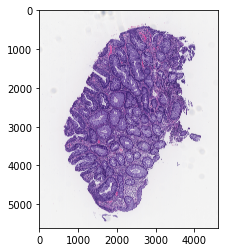

标签为：


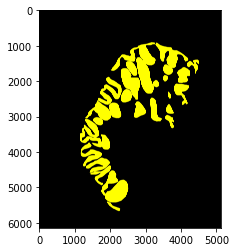

预测为：
(6144, 5120, 3)


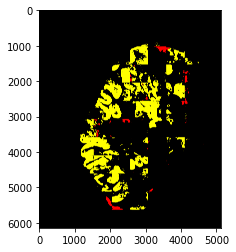

In [10]:

hehe = testDirs[2].replace(imageDir,"").replace(".png","")
#################################################image
print("原图为：")

test_wsi_mask = Image.open("/data3/digestpath_img_roi_downsample/"+hehe+".png").convert("RGB")
plt.imshow(test_wsi_mask)
plt.show()
h, w ,_= np.array(test_wsi_mask).shape
h+=1000
w+=1000
# print(h, w)

#################################################ground truth
print("标签为：")
patch_path = "/data3/digestpath_mask_patch/"+hehe+".png/"
patch =os.listdir(patch_path)
temp = np.ones((512,512,3))*0
num=0
all_patch_gt = 0
for i in range(w//512):
    lie = temp
    for j in range(h//512):
        num += 1
        if j ==0 and "%03d" %num+".png" in patch:
            lie = np.array(Image.open(patch_path+"%03d" %num+".png" ).convert("RGB"))
        elif j != 0  and "%03d" %num+".png" in patch:
            lie = np.concatenate((lie,np.array(Image.open(patch_path+"%03d" %num+".png" ).convert("RGB"))),0)
        elif j != 0  and "%03d" %num+".png" not in patch:
            lie = np.concatenate((lie,temp),0)
    if i == 0:
        all_patch_gt = lie
    else:
        all_patch_gt = np.concatenate((all_patch_gt, lie),1)
# print(all_patch_gt.shape)
plt.imshow(all_patch_gt/255)
plt.show()

###################################################prediction
print("预测为：")
patch_path = "/data3/digestpath_img_patch/"+hehe+".png/"
patch =os.listdir(patch_path)
temp = np.ones((512,512,3))*0
num=0
all_patch_pd = 0
for i in range(w//512):
    lie = temp
    for j in range(h//512):
        num += 1
        if j ==0 and "%03d" %num+".png" in patch:
            lie = predict_result(patch_path+"%03d" %num+".png" )
        elif j != 0  and "%03d" %num+".png" in patch:
            lie = np.concatenate((lie,predict_result(patch_path+"%03d" %num+".png" )),0)
        elif j != 0  and "%03d" %num+".png" not in patch:
            lie = np.concatenate((lie,temp),0)
    if i == 0:
        all_patch_pd = lie
    else:
        all_patch_pd = np.concatenate((all_patch_pd, lie),1)
print(all_patch_pd.shape)
plt.imshow(all_patch_pd/255)
plt.show()